# Modelling Galaxy Masses Using a Neural Network

In [1]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from astropy.table import Table
import json

In cosmology, calculating masses of galaxies is an important part of understanding galactic structure and dynamics. Discrepancies between the total baryonic mass of a galaxy and its mass as inferred from its dynamics was crucial in the discovery of dark matter, and being able to deduce the total mass of a galaxy from its light and colours remains an important exercise in improving scientific understanding of galaxies and cosmology. [Francis et al. (2025)](https://ui.adsabs.harvard.edu/link_gateway/2025AJ....169..186D/doi:10.3847/1538-3881/adaf21) present a model to convert Wide-field Infrared Spectroscopy Explorer (WISE) W1-band fluxes into stellar masses. As part of their work, they include a table of total stellar masses of a number of galaxies, alongside their total luminosity in the W1 band and g-W1 photometric colours. In this report, I train and test a neural network on this dataset. Specifically, this model retrieves the total mass of a galaxy based on inputs of galaxy luminosity and g-W1 colour.

The raw data from the study, retrieved from [SPARC](https://astroweb.case.edu/SPARC/) (associated with [Lelli, McGaugh and Schombert, 2016](https://ui.adsabs.harvard.edu/link_gateway/2016AJ....152..157L/doi:10.3847/0004-6256/152/6/157)), can be found in `wise_ii.table1.txt`. We start by extracting and viewing the data:

In [2]:
# load data
data = "wise_ii.table1.txt"
with open(data) as f:
    lines = f.readlines()

# process data
data = []
for line in lines[16:]: # remove header
    values = line.split()
    data.append([v for v in values])

data = pd.DataFrame(data, columns=['Galaxy', 'LogL', 'LogM', 'err_M', 'g-W1', 'M/L'])
data = data.astype({'Galaxy': 'str','LogL': 'float', 'LogM': 'float', 'err_M': 'float', 'g-W1': 'float', 'M/L': 'float'})
data = data.sample(frac=1).reset_index(drop=True) # shuffle data in case of bias in ordering
display(data)

,Galaxy,LogL,LogM,err_M,g-W1,M/L
0,UGC02487,11.934,11.754,0.004,4.38,0.66
1,UGC09037,10.734,10.595,0.019,3.29,0.73
2,NGC2683,10.856,10.903,0.004,4.19,1.11
3,UGC03580,10.311,10.065,0.005,3.00,0.57
4,UGC06983,9.711,9.446,0.034,2.81,0.54
...,...,...,...,...,...,...
106,UGC02023,9.091,8.829,0.027,2.35,0.55
107,NGC3741,7.455,7.192,0.023,2.44,0.55
108,UGC05414,9.239,8.975,0.029,2.64,0.54
109,NGC5033,11.010,11.057,0.006,4.06,1.11


Note that due to large numbers, we are dealing with logarithmic masses and luminosities. Both of these values are scaled according to solar quantities. g-W1 colours are in units of magnitude.

## Model Description

The model takes in two input variables:
1. $x_1=\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$
2. $x_2=g-\mathrm{W1}$

And produces one output:
1. $y_1=\log_{10}(\mathrm{Mass}/\mathrm{M}_\odot)$

We can visualise the training data using a 2D histogram of mass in the colour-luminosity plane, as well as plotting dependencies between the inputs and output individually. Note that the inputs have been normalised between 0 and 1 as is best practice.

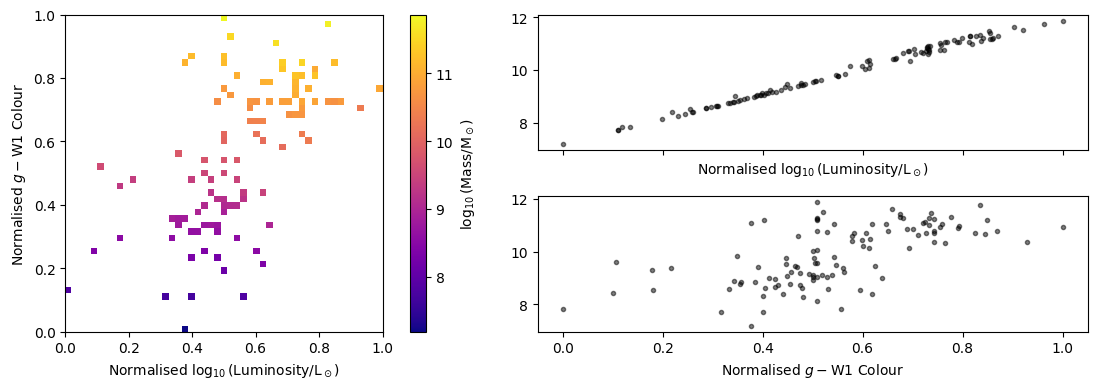

In [3]:
# set x and y
x = np.column_stack([data['LogL'], data['g-W1']])
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0)) # normalise
y = np.array(data['LogM']).reshape([-1,1])

# Create bins and setup 2D histogram
x_bins = np.linspace(x[:,0].min(), x[:,0].max(), 50)
y_bins = np.linspace(x[:,1].min(), x[:,1].max(), 50)
stat, x_edges, y_edges, binnumber = stats.binned_statistic_2d(x[:,0], x[:,1], y[:,0], statistic='mean', bins=[x_bins, y_bins])

# plotting
fig = plt.figure(figsize=(12, 4), tight_layout=True)

ax1 = fig.add_subplot(121)
im = ax1.imshow(stat, origin='lower', aspect='equal',
           extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
           cmap='plasma')
clb = plt.colorbar(im, label=r'$\log_{10}(\mathrm{Mass}/\mathrm{M}_\odot)$')
ax1.set_xlabel(r'Normalised $\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$')
ax1.set_ylabel(r'Normalised $g-\mathrm{W1}$ Colour')

ax2 = fig.add_subplot(222)
ax2.plot(x[:,0], y, 'k.', alpha=0.5)
ax2.tick_params(labelbottom=False)
ax2.set_xlabel(r'Normalised $\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$')

ax3 = fig.add_subplot(224)
ax3.plot(x[:,1], y, 'k.', alpha=0.5)
ax3.set_xlabel(r'Normalised $g-\mathrm{W1}$ Colour')

plt.show()

The above plots demonstrate a strong linear correlation between logarithmic luminosity and logarithmic mass, and a more scattered but still somewhat positive linear relation between g-W1 colour and logarithmic mass. We now split data into training, validation, and test sets using the 70/20/10 rule.

In [4]:
# split into training, validation, test sets
train_size = int(0.7 * len(x))
valid_size = int(0.2 * len(x))
test_size = len(x) - train_size - valid_size

x_train, x_valid, x_test = x[:train_size], x[train_size:train_size+valid_size], x[-test_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size+valid_size], y[-test_size:]

# check shapes
print("Training Data: {} {}".format(x_train.shape, y_train.shape))
print("Validation Data: {} {}".format(x_valid.shape, y_valid.shape))
print("Test Data: {} {}".format(x_test.shape, y_test.shape))

Training Data: (77, 2) (77, 1)
Validation Data: (22, 2) (22, 1)
Test Data: (12, 2) (12, 1)


## Network Architecture

### Activation Functions

Since this is a network for regression dealing with largely linear relationships, we use the ReLU activation function and linear output for regression. The below cell defines `relu(x)` and `linear(x)` as well as `relu_derivative(x)` for backpropagation.

In [5]:
# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# linear output for regression
def linear(x):
    return x

# ReLU derivative
def relu_derivative(x):
    results = np.ones_like(x)
    results[x < 0] = 0
    return results

### Network Structure

We can define the sizes of the network layers as follows:

In [6]:
# network sizes
input_layer = 2
hidden_layer = 8 # somewhat arbitrary choice
output_layer = 1

total_neurons = input_layer + hidden_layer + output_layer
print(f"Total neurons in network: {total_neurons}")

Total neurons in network: 11


We can also graphically represent the network structure as

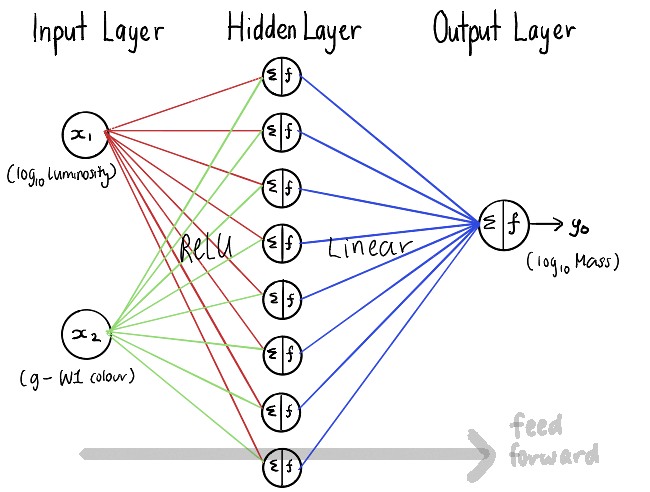

### Initialisation

Then we initialise weights and biases. Weights are initialised using a normal distribution with variance corresponding to the number of neurons. The randomness introduced as a result of this step speeds up training. Biases as simply initialised as zero vectors of size corresponding to the number of neurons in each layer.

In [7]:
# initialize weights and biases
init_scale = 0.01 # scale for better stability
rng = np.random.default_rng(42) # seed for reproducibility

w1 = init_scale * rng.normal(0, np.sqrt(2/input_layer), size=(hidden_layer, input_layer))
b1 = np.zeros((hidden_layer, 1))
w2 = init_scale * rng.normal(0, np.sqrt(2/hidden_layer), size=(output_layer, hidden_layer))
b2 = np.zeros((output_layer, 1))

Finally, we define the network functions, as previously discussed (ReLU for inputs to hidden layer and linear for hidden layer to output).

In [8]:
# defining network functions
def f_z(x,w,b):
    return (np.matmul(w, x.T)+b).T
# from inputs to hidden layer
def f_y1(x, w1, b1):
    z1 = f_z(x, w1, b1)
    return relu(z1)
# from hidden layer to output
def f_y2(y1, w2, b2):
    z2 = f_z(y1, w2, b2)
    return linear(z2)
# full feed forward
def feed_forward(x,w1,b1,w2,b2):
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)
    return y2

## Network Training

### Loss Function

Loss is taken to be a Root Mean Squared Error (RMSE) function as this is an efficient way to calculate the difference between the true and predicted values for $\log_{10}\mathrm{Mass}$. That is,
$$\text{Loss}_\text{RMSE}=\left(\frac{1}{111}\sum_{i=1}^{111}(y_{i,\text{true}}-y_{i,\text{pred}})\right)^{1/2}$$

In [9]:
# define loss function (RMSE)
def loss_rmse(y_true, y_pred):
    y_t = np.asarray(y_true)
    y_p = np.asarray(y_pred)
    return np.sqrt(np.mean((y_t - y_p)**2))

### Gradient Equations

If we set $y$, $y_1$ and $y_2$ to be the true output, and the outputs of the hidden and output layers, respectively, and note that the linear output function results in $z_2=y_2$, then the loss function is
$$L=\left(\frac{1}{111}\sum_{j=1}^{111}(y_j-y_{2j})^2\right)^{1/2}=\left(\frac{1}{111}\sum_{j=1}^{111}(y_j-z_{2j})^2\right)^{1/2}$$
The derivative over $z_{2i}$ is then
$$\frac{\partial{L}}{\partial{z_{2i}}}=\frac{1}{2}\left(\frac{1}{111}\sum_{j=1}^{111}(y_j-z_{2j})^2\right)^{-1/2}\cdot-2\delta_{ji}\sum_{j=1}^{111}(y_j-z_{2j})=\frac{y_{2i}-y_i}{L}$$
Using the chain rule to get derivatives over $w_2$ and $b_2$, where $k$ indexes the size of the training set i.e. $k\in[1,111]$, $j$ indexes the hidden layer i.e. $k\in[1,8]$, and $i$ indexes the output layer i.e. $i\in[1]$:
$$\frac{\partial{L}}{\partial{w_{2ij}}}=\sum_{k}\left(\frac{\partial{L}}{\partial{z_{2ki}}}\right)^T\frac{\partial{z_{2ki}}}{\partial{w_{2ij}}}=\sum_{k}\left(\frac{\partial{L}}{\partial{z_{2ki}}}\right)^Ty_{1kj}$$
$$\frac{\partial{L}}{\partial{b_{2i}}}=\sum_{k}\left(\frac{\partial{L}}{\partial{x_{2ki}}}\right)^T\frac{\partial{z_{2ki}}}{\partial{b_{2i}}}=\sum_{k}\frac{\partial{L}}{\partial{z_{2ki}}}$$
We can continue in the same way to get derivatives with respect to $z_1$, $w_1$, and $b_1$, noting that $q\in[1,222]$ indexes the shape and subscript of $x$ as $x_{kq}$:
$$\frac{\partial L}{\partial z_{1kj}} = \sum \limits_{i}\frac{\partial L}{\partial z_{2ki}} \frac{\partial z_{2ki}}{\partial y_{1kj}} \frac{\partial y_{1kj}}{\partial z_{1kj}} =  \sum \limits_{i} \frac{\partial L}{\partial z_{2ki}}w_{2ij}\frac{\partial y_{1kj}}{\partial z_{1kj}}$$
$$\frac{\partial L}{\partial w_{1jq}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)^T \frac{\partial z_{1kj}}{\partial w_{1jq}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)^T x_{kq}$$
$$\frac{\partial L}{\partial b_{1j}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)^T \frac{\partial z_{1kj}}{\partial b_{1j}} = \sum \limits_{k} \left(\frac{\partial L}{\partial z_{1kj}}\right)$$
Implementing all of the above into code as function `gradient_descent`:

In [10]:
def gradient_descent(x,y,w1,b1,w2,b2):

    z1 = f_z(x, w1, b1)
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)

    dLdz2 = (y2-y) / loss_rmse(y, y2)
    dLdw2 = np.matmul(dLdz2.T, y1) / len(y1)
    dLdb2 = np.sum(dLdz2, axis=0).reshape([-1,1]) / len(y1)

    dy1dz1 = relu_derivative(z1)

    dLdz1 = np.matmul(dLdz2, w2) * dy1dz1 / len(y1)
    dLdw1 = np.matmul(dLdz1.T, x)
    dLdb1 = np.sum(dLdz1, axis=0).reshape([-1,1])

    return {'dLdw1': dLdw1, 'dLdw2': dLdw2, 'dLdb1': dLdb1, 'dLdb2': dLdb2}

## Train and Test Network

The network is now ready to train. We want to test learning rates of 0.1 and 1 over 10 training steps (epochs). The easiest way to do this is to define a function `train_network` that takes in the desired learning rate and number of epochs as arguments, and sets weights and biases as previously defined. We also record a 'snapshot' of each epoch, that is, saving the weights, gradients, outputs, and loss for each of the ten steps when applied to the validation set. These collated snapshots are saved into .fits files for easier handling of multidimensional tables.

In [11]:
def train_network(l_rate, Nepoch, w1=w1, b1=b1, w2=w2, b2=b2):

    # Make local copies so repeated calls don't mutate the global initial weights
    w1 = w1.copy()
    b1 = b1.copy()
    w2 = w2.copy()
    b2 = b2.copy()

    loss_train = np.zeros(Nepoch)
    loss_valid = np.zeros(Nepoch)
    loss_test = np.zeros(Nepoch)
    snapshots = []  # will hold per-epoch dictionaries of weights, grads, outputs, losses

    for step in range(Nepoch):
        # evaluate current losses and outputs
        output_train = feed_forward(x_train, w1, b1, w2, b2)
        loss_train[step] = loss_rmse(y_train, output_train)
        output_valid = feed_forward(x_valid, w1, b1, w2, b2)
        loss_valid[step] = loss_rmse(y_valid, output_valid)

        # compute gradients on training set
        grad = gradient_descent(x_train, y_train, w1, b1, w2, b2)

        # record snapshot for this epoch
        snap = {
            'step': step+1,
            'w1': w1.tolist(),
            'b1': b1.tolist(),
            'w2': w2.tolist(),
            'b2': b2.tolist(),
            'dLdw1': grad['dLdw1'].tolist(),
            'dLdb1': grad['dLdb1'].tolist(),
            'dLdw2': grad['dLdw2'].tolist(),
            'dLdb2': grad['dLdb2'].tolist(),
            'output': output_valid.flatten().tolist(),
            'loss': float(loss_valid[step]),
        }
        snapshots.append(snap)

        # update weights
        w1 = w1 - l_rate * grad['dLdw1']
        b1 = b1 - l_rate * grad['dLdb1']
        w2 = w2 - l_rate * grad['dLdw2']
        b2 = b2 - l_rate * grad['dLdb2']

    # save FITS file of snapshots table
    steps = np.array([s['step'] for s in snapshots])

    cols = {}
    cols['w1'] = [json.dumps(s['w1']) for s in snapshots]
    cols['b1'] = [json.dumps(s['b1']) for s in snapshots]
    cols['w2'] = [json.dumps(s['w2']) for s in snapshots]
    cols['b2'] = [json.dumps(s['b2']) for s in snapshots]
    cols['dLdw1'] = [json.dumps(s['dLdw1']) for s in snapshots]
    cols['dLdb1'] = [json.dumps(s['dLdb1']) for s in snapshots]
    cols['dLdw2'] = [json.dumps(s['dLdw2']) for s in snapshots]
    cols['dLdb2'] = [json.dumps(s['dLdb2']) for s in snapshots]
    cols['output'] = [json.dumps(s['output']) for s in snapshots]
    loss_arr = np.array([s['loss'] for s in snapshots])

    tbl = Table()
    tbl['step'] = steps

    for name, lst in cols.items():
        maxlen = max(len(s) for s in lst) if len(lst) > 0 else 1
        # add a small margin
        maxlen = maxlen + 5
        byte_arr = np.array([s.encode('utf-8') for s in lst], dtype=f'S{maxlen}')
        tbl[name] = byte_arr

    tbl['loss'] = loss_arr

    fitsname = f"snapshot_lr_{l_rate}_{Nepoch}.fits"
    tbl.write(fitsname, format='fits', overwrite=True)
    print(f"Wrote FITS snapshots to {fitsname}")

    return loss_train, loss_valid

### Comparing Learning Rates

We now run `train_network` for learning rates of 0.1 and 1 over 10 epochs. A visual comparison of the performance of the learning rates can be made by plotting the loss on training and validation sets as a function of epoch, for both learning rates. At the same time, files will be saved containing tables specifying the more detailed performance of the model with different learning rates over the ten training steps.

Wrote FITS snapshots to snapshot_lr_0.1_10.fits
Wrote FITS snapshots to snapshot_lr_1_10.fits


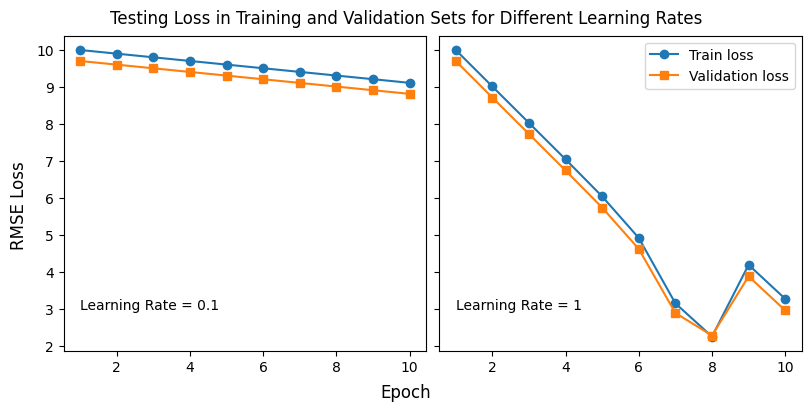

In [12]:
Nepoch = 10
l_rates = [0.1, 1]

fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True, constrained_layout=True)
epochs = np.arange(1, Nepoch+1)

tables = {}
for idx, lr in enumerate(l_rates):
    loss_train, loss_valid = train_network(lr, Nepoch)

    ax[idx].plot(epochs, loss_train, marker='o', label='Train loss')
    ax[idx].plot(epochs, loss_valid, marker='s', label='Validation loss')
    ax[idx].text(1, 3, f"Learning Rate = {lr}")

ax[1].legend(loc='upper right')
fig.suptitle("Testing Loss in Training and Validation Sets for Different Learning Rates")
fig.supxlabel("Epoch")
fig.supylabel("RMSE Loss")

plt.show()

As we can see in the above plots, loss monotonically decreases over 10 epochs with a learning rate of 0.1, but when a learning rate of 1 is used, there is an increase in loss within 10 steps. We can access the tables listing weights, gradients, outputs, and loss of the ten steps on the validation set by unpacking the previously saved .fits files. The below cells defines some functions to do this, followed by a series of usage examples. The tables can also be viewed using TopCat.

In [13]:
# loading saved FITS files
data_lr_0_1 = Table.read("snapshot_lr_0.1_10.fits", format='fits')
data_lr_1 = Table.read("snapshot_lr_1_10.fits", format='fits')

# helper to decode entries stored as bytes or JSON strings
def _decode_entry(e):
    if isinstance(e, (bytes, np.bytes_)):
        s = e.decode('utf-8')
    else:
        s = e
    try:
        return json.loads(s)
    except Exception:
        return s

# function to unpack values from columns in table
def unpack_column(table, colname, epoch=None):
    """
    If epoch is provided (1-based), return the decoded value for that epoch.

    - For matrix-like columns (e.g. 'w1') this will return a pandas DataFrame
      with rows = neurons and columns = input features (e.g. 8 x 2) when there
      are multiple neuron rows; DataFrame rows are indexed 1..N.
    - For single-row matrices (e.g. dLdw2 with shape (1, N)) this returns a 1D
      numpy array.
    - For 1D arrays this returns a pandas Series indexed 1..N.

    If epoch is None, returns a list of decoded entries (one per epoch).
    """
    col = table[colname]

    if epoch is not None:
        idx = epoch - 1
        raw = col[idx]
        decoded = _decode_entry(raw)
        arr = np.array(decoded)

        if arr.ndim == 2:
            if arr.shape[0] > 1:
                ncols = arr.shape[1]
                colnames = [f"x{i+1}" for i in range(ncols)]
                df = pd.DataFrame(arr, columns=colnames)
                df.index = np.arange(1, len(df) + 1)
                return df
            else:
                return arr.flatten()
        elif arr.ndim == 1:
            s = pd.Series(arr)
            s.index = np.arange(1, len(s) + 1)
            return s
        else:
            return arr
    else:
        # return a list of decoded entries for all epochs
        return [_decode_entry(c) for c in col]


def unpack_data_point(table, column, data_point=1):
    """
    Returns the requested column (e.g. output) across all epochs for a specified data point
    in the validation set.
    """
    cols_all = unpack_column(table, column)  # list of arrays/lists, one per epoch
    idx = int(data_point) - 1
    values = []
    for out in cols_all:
        arr = np.asarray(out)
        if idx < arr.shape[0]:
            values.append(arr[idx])
        else:
            values.append(np.nan)
    epochs = np.arange(1, len(values) + 1)
    df = pd.DataFrame({
        'epoch': epochs,
        column: values
    })
    return df.to_string(index=False)

#### Use Cases

In [14]:
# e.g. to get loss of each epoch for learning rate 0.1
print("Loss for learning rate 0.1:\n", data_lr_0_1['loss'], "\n")

Loss for learning rate 0.1:
        loss      
-----------------
9.708670487082513
9.609761033735763
9.510875695897296
9.412013026366905
9.313171619792561
9.214349960106643
9.115546294472429
9.016758462053094
8.917983711070455
8.819218480463435 



In [15]:
# e.g. to get the w1 weights for epoch 1 for learning rate 1 (will be 8x2 DataFrame)
print("w1 weights for epoch 1 and learning rate 1:")
display(unpack_column(data_lr_1, 'w1', 1))

w1 weights for epoch 1 and learning rate 1:


,x1,x2
1,0.003047,-0.010400
2,0.007505,0.009406
3,-0.019510,-0.013022
4,0.001278,-0.003162
5,-0.000168,-0.008530
6,0.008794,0.007778
7,0.000660,0.011272
8,0.004675,-0.008593


In [16]:
# e.g. to get the dLdw2 gradients for epoch 5 for learning rate 0.1 (returned as 1D numpy array)
print("dLdw2 gradients for epoch 5 and learning rate 0.1:")
print(unpack_column(data_lr_0_1, 'dLdw2', 5))

dLdw2 gradients for epoch 5 and learning rate 0.1:
[-4.18505711e-06 -7.58788375e-03  0.00000000e+00 -1.91143267e-06
  0.00000000e+00 -8.33317059e-03 -1.17006299e-02 -3.30576837e-05]


In [17]:
# e.g. to get the output across all saved epochs for the first validation data point
print("Output for first validation data point across all epochs for learning rate 1:")
print(unpack_data_point(data_lr_0_1, 'output', data_point=1))

Output for first validation data point across all epochs for learning rate 1:
 epoch    output
     1 -0.000018
     2  0.099383
     3  0.198771
     4  0.298147
     5  0.397513
     6  0.496868
     7  0.596216
     8  0.695557
     9  0.794895
    10  0.894231


## Final Performace Example

This isn't a part of the assignment, but we can see from the tables and plots above that 10 training steps with a learning rate of 0.1 isn't enough for our neural network to come anywhere close to resolving the true galaxy masses in out dataset. I therefore include the following to demonstrate that increasing epochs can indeed result in successful training of the neural network. Here, I use the validation set and a learning rate of 0.1 to train the neural network over 50 epochs and plot the result.

Wrote FITS snapshots to snapshot_lr_0.1_50.fits


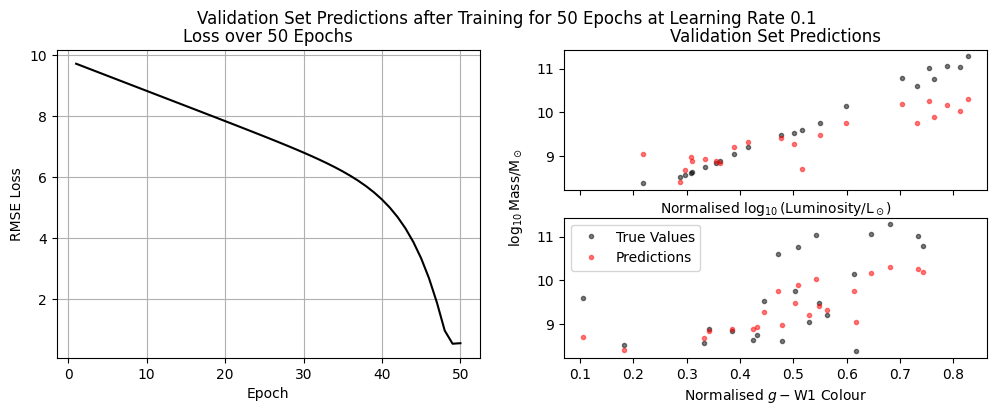

In [18]:
_, loss_valid = train_network(l_rate=0.1, Nepoch=50)
data_final = Table.read("snapshot_lr_0.1_50.fits", format='fits')

output = unpack_column(data_final, 'output', epoch=50)
fig = plt.figure(figsize=(12,4))

ax1 =  fig.add_subplot(121)
ax1.plot(np.arange(1,51), loss_valid, 'k')
ax1.grid()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RMSE Loss")
ax1.set_title("Loss over 50 Epochs")

ax2 = fig.add_subplot(222)
ax2.tick_params(labelbottom=False)
ax2.plot(x_valid[:,0], y_valid[:,0], 'k.', alpha=0.5)
ax2.plot(x_valid[:,0], output, 'r.', alpha=0.5)
ax2.set_xlabel(r"Normalised $\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$")
ax2.set_title("Validation Set Predictions")

ax3 = fig.add_subplot(224, sharex=ax2)
ax3.plot(x_valid[:,1], y_valid[:,0], 'k.', alpha=0.5, label='True Values')
ax3.plot(x_valid[:,1], output, 'r.', alpha=0.5, label='Predictions')
ax3.set_xlabel(r"Normalised $g-\mathrm{W1}$ Colour")
ax3.legend()

fig.text(0.5, 0.4, r'$\log_{10}\mathrm{Mass}/\mathrm{M}_\odot$', rotation=90)
fig.suptitle("Validation Set Predictions after Training for 50 Epochs at Learning Rate 0.1")

plt.show()
